In [1]:
import rdkit.Chem as Chem
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch_geometric.nn as geom_nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from dataset import ASODataset
from graph_fn import onehot_reactant_batch

In [3]:
a = ASODataset(onehot_reactant_batch)

c:\Users\Haoyu Fan\Desktop\GNN\GNN_enantioselectivity\ASOhelpers.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


In [4]:
from trainer import Trainer

In [2]:
#generate a dictionary of ligand
import csv
from torch_geometric.data import Data
with open('ligands.csv') as f:
    reader = csv.reader(f)
    ligands = list(reader)
f.close()
ligand_dict = {}
for p in ligands:
    ligand_dict[p[0]] = p[1]

In [3]:
#generate a dictionary of smile strings of reactants
#there are only 5 thiols (string that contains S) and 5 imines (straings that contains N)
reactant_dict = {}
reactant_dict['1'] = 'O=C(/N=C/C1=CC=CC=C1)C2=CC=CC=C2'
reactant_dict['2'] = 'O=C(/N=C/C1=CC=C(C(F)(F)F)C=C1)C2=CC=CC=C2'
reactant_dict['3'] = 'O=C(/N=C/C1=CC=C(OC)C=C1)C2=CC=CC=C2'
reactant_dict['4'] = 'O=C(/N=C/C1=C(C=CC=C2)C2=CC=C1)C3=CC=CC=C3'
reactant_dict['5'] = 'O=C(/N=C/C1=C(C)C=CC=C1)C2=CC=CC=C2'

reactant_dict['A'] = 'SC1=CC=CC=C1'
reactant_dict['B'] = 'SCC'
reactant_dict['C'] = 'SC1CCCCC1'
reactant_dict['D'] = 'SC1=CC=C(OC)C=C1'
reactant_dict['E'] = 'SC1=C(C)C=CC=C1'

In [4]:
#parse the naming of reaction into ligand and two reactants
#the original dataset name the reaction as something like "1_i_1_A"
def parse_reaction(reaction_string):
    thiol = reaction_string[-1]
    reaction_string = reaction_string[:-1]
    reaction_string = reaction_string[:-1]
    imine = reaction_string[-1]
    reaction_string = reaction_string[:-1]
    ligand = reaction_string[:-1]
    return ligand_dict[ligand], reactant_dict[thiol], reactant_dict[imine], thiol, imine

In [5]:
#generate features of nodes and edges
elem_list = ['C', 'N', 'O', 'F', 'Si', 'P','Cl', 'Br','unknown']
bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
atom_fdim = len(elem_list) + 5
bond_fdim = 5
with open('exps.csv') as f:
    reader = csv.reader(f)
    reactions = list(reader)
f.close()

def onek_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))    

def atom_features(atom):
    return np.array(onek_encoding_unk(atom.GetSymbol(), elem_list) 
            + [atom.GetFormalCharge()] 
            + [atom.GetDegree()]
            + [atom.GetExplicitValence()]
            + [atom.GetImplicitValence()]
            + [atom.GetIsAromatic()], dtype=np.float32)

def bond_features(bond):
    bt = bond.GetBondType()
    return np.array([bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE, bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC, bond.IsInRing()], dtype=np.float32)


def generate_attrs(smile):
    mol = Chem.MolFromSmiles(smile)
    
    x = []
    for i in range(mol.GetNumAtoms()):
        x.append(atom_features(mol.GetAtomWithIdx(i)))
    x = torch.tensor(np.array(x), dtype=torch.float)
    
    edge_attr = []
    edge_index = [[],[]]
    bonds = mol.GetBonds()
    for b in bonds:
        edge_index[0].append(b.GetBeginAtomIdx())
        edge_index[0].append(b.GetEndAtomIdx())
        
        edge_index[1].append(b.GetEndAtomIdx())
        edge_index[1].append(b.GetBeginAtomIdx())
        
        edge_attr.append(bond_features(b))
        edge_attr.append(bond_features(b))
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return x,edge_index,edge_attr

In [6]:
#generate reactants and ligands in a single graph as not connected components
def generate_attrs_all(ligand_smile,thiol_smile,imine_smile):
    ligand = Chem.MolFromSmiles(ligand_smile)
    thiol = Chem.MolFromSmiles(thiol_smile)
    imine = Chem.MolFromSmiles(imine_smile)
    
    ligand_atom_num = ligand.GetNumAtoms()
    thiol_atom_num = thiol.GetNumAtoms()
    imine_atom_num = imine.GetNumAtoms()
    
    x = []
    for i in range(ligand_atom_num):
        x.append(atom_features(ligand.GetAtomWithIdx(i)))
    for i in range(thiol_atom_num):
        x.append(atom_features(thiol.GetAtomWithIdx(i)))
    for i in range(imine_atom_num):
        x.append(atom_features(imine.GetAtomWithIdx(i)))
    x = torch.tensor(np.array(x), dtype=torch.float)
    
    
    edge_attr = []
    edge_index = [[],[]]
    bonds = ligand.GetBonds()
    for b in bonds:
        edge_index[0].append(b.GetBeginAtomIdx())
        edge_index[0].append(b.GetEndAtomIdx())
        
        edge_index[1].append(b.GetEndAtomIdx())
        edge_index[1].append(b.GetBeginAtomIdx())
        
        edge_attr.append(bond_features(b))
        edge_attr.append(bond_features(b))
        
    bonds = thiol.GetBonds()
    for b in bonds:
        edge_index[0].append(b.GetBeginAtomIdx() + ligand_atom_num)
        edge_index[0].append(b.GetEndAtomIdx()+ ligand_atom_num)
        
        edge_index[1].append(b.GetEndAtomIdx() + ligand_atom_num)
        edge_index[1].append(b.GetBeginAtomIdx() + ligand_atom_num)
        
        edge_attr.append(bond_features(b))
        edge_attr.append(bond_features(b))
    
    bonds = imine.GetBonds()
    for b in bonds:
        edge_index[0].append(b.GetBeginAtomIdx() + ligand_atom_num + thiol_atom_num)
        edge_index[0].append(b.GetEndAtomIdx()+ ligand_atom_num + thiol_atom_num)
        
        edge_index[1].append(b.GetEndAtomIdx() + ligand_atom_num + thiol_atom_num)
        edge_index[1].append(b.GetBeginAtomIdx() + ligand_atom_num + thiol_atom_num)
        
        edge_attr.append(bond_features(b))
        edge_attr.append(bond_features(b))
    
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return x,edge_index,edge_attr

In [7]:
with open('exps.csv') as f:
    reader = csv.reader(f)
    reactions = list(reader)
f.close()

In [8]:
# =============== Just Ignore

# data structure that stores three graphs of ligand/thiol/imine (l,t,i), inherits from torch_geometric.data.Data
# edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
# x: Node feature matrix with shape [num_nodes, num_node_features]
# edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

# Note: In the actual dummy model, I only use graph of ligand as torch_geometric.data.Data, and treat thiol and imine as one hot encoding,
#        so this data structure is not really necessary.

class ReactionData(Data):
    def __init__(self, edge_index_l=None, edge_attr_l=None, x_l=None, 
                 edge_index_t=None, edge_attr_t=None, x_t=None,
                 edge_index_i=None, edge_attr_i=None, x_i=None, y=None):
        super().__init__()
        self.edge_index_l = edge_index_l
        self.edge_attr_l = edge_attr_l
        self.x_l = x_l
        
        self.edge_index_t = edge_index_t
        self.edge_attr_t = edge_attr_t
        self.x_t = x_t
        
        self.edge_index_i = edge_index_i
        self.edge_attr_i = edge_attr_i
        self.x_i = x_i
        
        self.y = y
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_l':
            return self.x_l.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        if key == 'edge_index_i':
            return self.x_i.size(0)
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [9]:
#generate data where catalyst, thiol, and imine are put in the same graph. Graphs are torch_geometric.data.Data class.
single_graph_data = []
all_data = []
thiols = ['A','B','C','D','E']
imines = ['1','2','3','4','5']
for r in reactions:
    data = r[0].split()
    y = (float(data[-1]) + 100)/ 200
    reaction_string = data[0]
    ligand, thiol, imine, t_key, i_key = parse_reaction(reaction_string)
    
    x, edge_index, edge_attr = generate_attrs_all(ligand, thiol, imine)
    r = Data(edge_index=edge_index, edge_attr=edge_attr, x=x, y = y)
    r.name = ligand + " " + thiol + " " + imine
    single_graph_data.append(r)

C:\Users\Haoyu Fan\AppData\Local\Temp\ipykernel_11412\4252274128.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


In [10]:
#generate data where only catalyst is in the graph. Graphs are torch_geometric.data.Data class.
all_data = []
thiols = ['A','B','C','D','E']
imines = ['1','2','3','4','5']
for r in reactions:
    data = r[0].split()
    y = (float(data[-1]) + 100)/ 200
    reaction_string = data[0]
    ligand, thiol, imine, t_key, i_key = parse_reaction(reaction_string)
    
    x_l, edge_index_l, edge_attr_l = generate_attrs(ligand)
    x_t, edge_index_t, edge_attr_t = generate_attrs(thiol)
    x_i, edge_index_i, edge_attr_i = generate_attrs(imine)
    
    thiol_vec = []
    imine_vec = []
    for i in range(5):
        if t_key == thiols[i]:
            thiol_vec.append(1)
        else:
            thiol_vec.append(0)
        if i_key == imines[i]:
            imine_vec.append(1)
        else:
            imine_vec.append(0)
    '''
    r = ReactionData(edge_index_l=edge_index_l, edge_attr_l=edge_attr_l, x_l=x_l,
                       edge_index_t=edge_index_t, edge_attr_t=edge_attr_t, x_t=x_t,
                       edge_index_i=edge_index_i, edge_attr_i=edge_attr_i, x_i=x_i, y=y)
                       '''
    r = Data(edge_index=edge_index_l, edge_attr=edge_attr_l, x=x_l, y = y)
    r['reactant_vec'] = torch.tensor(thiol_vec + imine_vec)    
    r.name = ligand + " " + thiol + " " + imine
    all_data.append(r)

In [8]:
train_data, val_data = train_test_split(a.data, test_size = 0.1, random_state = 42)

In [12]:
sg_train_data, sg_val_data = train_test_split(single_graph_data, test_size = 0.1, random_state = 42)

In [6]:
#hyperparameters
LEARNING_RATE = 7.5e-3
BATCH_SIZE = 16
NODE_INPUT_SIZE = 14
OUTPUT_SIZE_BEFORE_POOL = 30
NODE_HIDDEN_SIZE = 60
GLOB_VEC_SIZE = 10
EPOCHS = 50
DROP_OUT = 0
BOND_ATTR = 5

In [5]:
class GNNModel(nn.Module):
    #dummy model not using edge information
    #d_glob is the dimension of one-hot-encoded reactants
    def __init__(self, d_in, d_hidden, d_out, d_glob, num_layers=2, dp_rate=0, **kwargs):
        super().__init__()
        conv_layer = geom_nn.GCNConv
        
        graph_layers = []
        in_channels, out_channels = d_in, d_hidden
        for l_idx in range(num_layers-1):
            graph_layers += [
                conv_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)]
            in_channels = d_hidden
        graph_layers += [conv_layer(in_channels=in_channels, out_channels=d_out,**kwargs)]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.head = nn.Sequential(
            nn.Dropout(dp_rate),
            nn.Linear(d_out + d_glob, 10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )

    #glob_vecs are the one hot encoding of reactants
    def forward(self, x, edge_index, edge_attr, batch_idx, glob_vecs):
        for l in self.graph_layers:
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index.long())
            else:
                x = l(x)
        x = geom_nn.global_mean_pool(x, batch_idx)
        x = torch.cat((x, glob_vecs.reshape(-1,10)),1)
        x = self.head(x)
        return x

In [15]:
class GNNModel_sg(nn.Module):
    #dummy model not using edge information
    #for data with ligand and reactants put in the same graph
    def __init__(self, d_in, d_hidden, d_out, num_layers=2, dp_rate=0, **kwargs):
        super().__init__()
        conv_layer = geom_nn.GCNConv
        
        graph_layers = []
        in_channels, out_channels = d_in, d_hidden
        for l_idx in range(num_layers-1):
            graph_layers += [
                conv_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)]
            in_channels = d_hidden
        graph_layers += [conv_layer(in_channels=in_channels, out_channels=d_out,**kwargs)]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.head = nn.Sequential(
            nn.Dropout(dp_rate),
            nn.Linear(d_out, 10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )

    def forward(self, x, edge_index, edge_attr, batch_idx):
        for l in self.graph_layers:
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index.long())
            else:
                x = l(x)
        x = geom_nn.global_mean_pool(x, batch_idx)
        x = self.head(x)
        return x

In [7]:
from torch.optim.lr_scheduler import ExponentialLR

In [9]:
device = torch.device('cuda')
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

model = GNNModel(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, GLOB_VEC_SIZE, num_layers=2, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

In [12]:
t = Trainer(model, device, optimizer, scheduler, glob_v= True)

Epoch: 001, Train Loss: 0.5034, Test Loss: 0.5335, Train MSE: 0.0208, Test MSE: 0.0251, , Train R2: 0.0991, Test R2: 0.0225
Epoch: 002, Train Loss: 0.4953, Test Loss: 0.5284, Train MSE: 0.0180, Test MSE: 0.0232, , Train R2: 0.2208, Test R2: 0.0962
Epoch: 003, Train Loss: 0.4926, Test Loss: 0.5266, Train MSE: 0.0169, Test MSE: 0.0226, , Train R2: 0.2662, Test R2: 0.1193
Epoch: 004, Train Loss: 0.4953, Test Loss: 0.5301, Train MSE: 0.0182, Test MSE: 0.0237, , Train R2: 0.2104, Test R2: 0.0786
Epoch: 005, Train Loss: 0.4893, Test Loss: 0.5233, Train MSE: 0.0159, Test MSE: 0.0214, , Train R2: 0.3108, Test R2: 0.1649
Epoch: 006, Train Loss: 0.4800, Test Loss: 0.5091, Train MSE: 0.0128, Test MSE: 0.0167, , Train R2: 0.4434, Test R2: 0.3496
Epoch: 007, Train Loss: 0.4732, Test Loss: 0.5004, Train MSE: 0.0105, Test MSE: 0.0135, , Train R2: 0.5441, Test R2: 0.4725
Epoch: 008, Train Loss: 0.4648, Test Loss: 0.4900, Train MSE: 0.0079, Test MSE: 0.0100, , Train R2: 0.6587, Test R2: 0.6112
Epoch: 0

array([0.4509044 , 0.0031296 , 0.86421579, 0.47380024, 0.00434158,
       0.83086692])

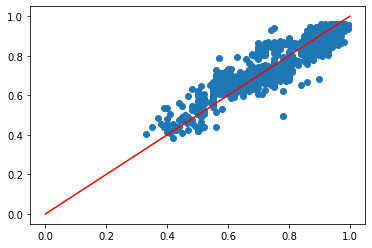

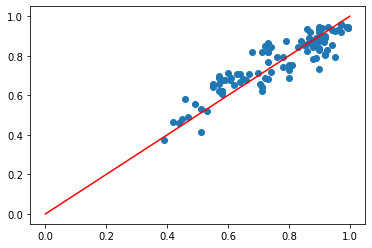

In [13]:
t.train(train_loader, val_loader, nn.BCELoss, EPOCHS)

In [10]:
def train(model, train_loader, glob_v = True):
    model.train()
    for data in train_loader:
        if not glob_v:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        else:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.reactant_vec)
        out = out.reshape(-1)
        loss = nn.BCELoss()(out.reshape(-1), data.y)
        loss.backward()
        optimizer.step() ####### needs to rewrite, put optimizer as arguement of train()
        optimizer.zero_grad()

In [11]:
%matplotlib inline
def test(model,loader, plot_flag, glob_v= True):
    model.eval()
    outputs = None
    targets = None
    with torch.no_grad():
        for data in loader:
            if not glob_v:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch).cpu()
            else:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.reactant_vec).cpu()
            if outputs == None:
                targets = data.y
                outputs = out
            else:
                outputs = torch.cat((outputs, out),0)
                targets = torch.cat((targets, data.y),0)
        #print(np.array(outputs)-np.array(targets))
    outputs = outputs.reshape(-1)
    r2 = r2_score(targets.numpy(), outputs.numpy())
    if plot_flag:
        plt.figure()
        plt.scatter(targets.numpy(), outputs.numpy())
        x = y = np.linspace(0,1,100)
        plt.plot(x, y, '-r', label='y=x')
    return nn.BCELoss()(outputs, targets), nn.MSELoss()(targets, outputs), r2

In [12]:
#best when OUTPUT_SIZE_BEFORE_POOL is 20
#one hot encoded reactants
device = torch.device('cuda')
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)

model = GNNModel(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, GLOB_VEC_SIZE, num_layers=2, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

Epoch: 000, Train Loss: 0.5003, Test Loss: 0.5289, Train MSE: 0.0195, Test MSE: 0.0234, , Train R2: 0.1545, Test R2: 0.0882
Epoch: 001, Train Loss: 0.4944, Test Loss: 0.5277, Train MSE: 0.0175, Test MSE: 0.0230, , Train R2: 0.2393, Test R2: 0.1053
Epoch: 002, Train Loss: 0.4988, Test Loss: 0.5378, Train MSE: 0.0190, Test MSE: 0.0256, , Train R2: 0.1748, Test R2: 0.0019
Epoch: 003, Train Loss: 0.4908, Test Loss: 0.5241, Train MSE: 0.0163, Test MSE: 0.0218, , Train R2: 0.2914, Test R2: 0.1525
Epoch: 004, Train Loss: 0.4866, Test Loss: 0.5197, Train MSE: 0.0151, Test MSE: 0.0203, , Train R2: 0.3454, Test R2: 0.2092
Epoch: 005, Train Loss: 0.4826, Test Loss: 0.5148, Train MSE: 0.0141, Test MSE: 0.0187, , Train R2: 0.3883, Test R2: 0.2730
Epoch: 006, Train Loss: 0.4873, Test Loss: 0.5135, Train MSE: 0.0151, Test MSE: 0.0182, , Train R2: 0.3441, Test R2: 0.2919
Epoch: 007, Train Loss: 0.4742, Test Loss: 0.5013, Train MSE: 0.0107, Test MSE: 0.0137, , Train R2: 0.5362, Test R2: 0.4645
Epoch: 0

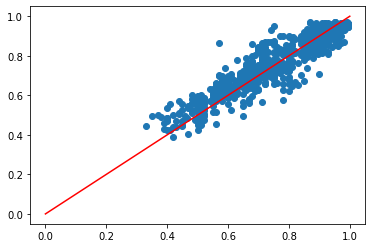

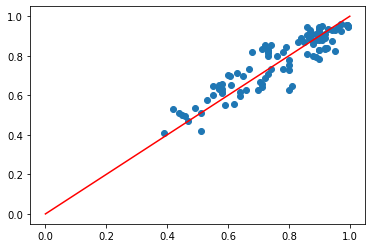

In [13]:
#axes of graphs are percentage of one enantiomer here
for epoch in range(EPOCHS):
        train(model, train_loader)
        scheduler.step()
        train_loss, train_MSE, train_r2 = test(model, train_loader, epoch == EPOCHS - 1)
        test_loss, test_MSE, test_r2 = test(model, val_loader, epoch == EPOCHS - 1)
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train MSE: {train_MSE:.4f}, Test MSE: {test_MSE:.4f}, , Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')

In [44]:
#not one hot encoded reactants, no bond features
device = torch.device('cuda')
sg_train_loader = DataLoader(sg_train_data, batch_size = BATCH_SIZE, shuffle = True)
sg_val_loader = DataLoader(sg_val_data, batch_size = BATCH_SIZE, shuffle = False)

model = GNNModel_sg(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, num_layers=2, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

Epoch: 000, Train Loss: 0.5091, Test Loss: 0.5345, Train MSE: 0.0225, Test MSE: 0.0254, , Train R2: 0.0228, Test R2: 0.0102
Epoch: 001, Train Loss: 0.5092, Test Loss: 0.5363, Train MSE: 0.0226, Test MSE: 0.0260, , Train R2: 0.0202, Test R2: -0.0129
Epoch: 002, Train Loss: 0.5102, Test Loss: 0.5323, Train MSE: 0.0228, Test MSE: 0.0246, , Train R2: 0.0089, Test R2: 0.0430
Epoch: 003, Train Loss: 0.5070, Test Loss: 0.5324, Train MSE: 0.0218, Test MSE: 0.0247, , Train R2: 0.0523, Test R2: 0.0372
Epoch: 004, Train Loss: 0.5058, Test Loss: 0.5313, Train MSE: 0.0215, Test MSE: 0.0244, , Train R2: 0.0680, Test R2: 0.0510
Epoch: 005, Train Loss: 0.5043, Test Loss: 0.5298, Train MSE: 0.0210, Test MSE: 0.0239, , Train R2: 0.0880, Test R2: 0.0689
Epoch: 006, Train Loss: 0.5020, Test Loss: 0.5276, Train MSE: 0.0203, Test MSE: 0.0232, , Train R2: 0.1172, Test R2: 0.0954
Epoch: 007, Train Loss: 0.5000, Test Loss: 0.5262, Train MSE: 0.0198, Test MSE: 0.0228, , Train R2: 0.1427, Test R2: 0.1132
Epoch: 

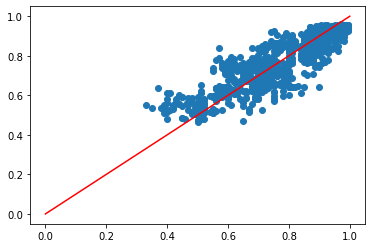

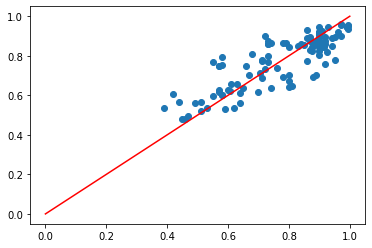

In [45]:
for epoch in range(EPOCHS):
    train(model, sg_train_loader, glob_v = False)
    scheduler.step()
    train_loss, train_MSE, train_r2 = test(model, sg_train_loader, epoch == EPOCHS - 1, glob_v = False)
    test_loss, test_MSE, test_r2 = test(model, sg_val_loader, epoch == EPOCHS - 1, glob_v = False)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train MSE: {train_MSE:.4f}, Test MSE: {test_MSE:.4f}, , Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')

In [19]:
class GNNModel_sg_edge_attr(nn.Module):
    #uses bond features as well
    #for data with ligand and reactants put in the same graph
    def __init__(self, d_in, d_hidden, d_out, num_layers=2, dp_rate=0, **kwargs):
        super().__init__()
        graph_layers = []
        in_channels, out_channels = d_in, d_hidden
        for l_idx in range(num_layers-1):
            graph_layers += [
                geom_nn.GINEConv(nn.Sequential(nn.Linear(in_channels, out_channels)), train_eps = True, edge_dim = BOND_ATTR),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)]
            in_channels = d_hidden
        graph_layers += [geom_nn.GINEConv(nn.Sequential(nn.Linear(in_channels, d_out)), train_eps = True, edge_dim = BOND_ATTR)]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.head = nn.Sequential(
            nn.Dropout(dp_rate),
            nn.Linear(d_out, 10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )

    #glob_vecs are the one hot encoding of reactants
    def forward(self, x, edge_index, edge_attr, batch_idx):
        for l in self.graph_layers:
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index.long(),edge_attr = edge_attr)
            else:
                x = l(x)
        x = geom_nn.global_mean_pool(x, batch_idx)
        x = self.head(x)
        return x

In [51]:
#not one hot encoded reactants, with bond features
device = torch.device('cuda')
sg_train_loader = DataLoader(sg_train_data, batch_size = BATCH_SIZE, shuffle = True)
sg_val_loader = DataLoader(sg_val_data, batch_size = BATCH_SIZE, shuffle = False)

model_edge_attr = GNNModel_sg_edge_attr(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, num_layers=2, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model_edge_attr.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

Epoch: 000, Train Loss: 0.5092, Test Loss: 0.5323, Train MSE: 0.0225, Test MSE: 0.0246, , Train R2: 0.0222, Test R2: 0.0417
Epoch: 001, Train Loss: 0.5272, Test Loss: 0.5438, Train MSE: 0.0294, Test MSE: 0.0290, , Train R2: -0.2762, Test R2: -0.1288
Epoch: 002, Train Loss: 0.5081, Test Loss: 0.5313, Train MSE: 0.0222, Test MSE: 0.0243, , Train R2: 0.0383, Test R2: 0.0547
Epoch: 003, Train Loss: 0.5071, Test Loss: 0.5308, Train MSE: 0.0218, Test MSE: 0.0241, , Train R2: 0.0527, Test R2: 0.0603
Epoch: 004, Train Loss: 0.5069, Test Loss: 0.5327, Train MSE: 0.0218, Test MSE: 0.0249, , Train R2: 0.0520, Test R2: 0.0319
Epoch: 005, Train Loss: 0.5061, Test Loss: 0.5311, Train MSE: 0.0216, Test MSE: 0.0243, , Train R2: 0.0644, Test R2: 0.0537
Epoch: 006, Train Loss: 0.5046, Test Loss: 0.5290, Train MSE: 0.0211, Test MSE: 0.0236, , Train R2: 0.0864, Test R2: 0.0819
Epoch: 007, Train Loss: 0.5071, Test Loss: 0.5352, Train MSE: 0.0220, Test MSE: 0.0257, , Train R2: 0.0453, Test R2: 0.0003
Epoch:

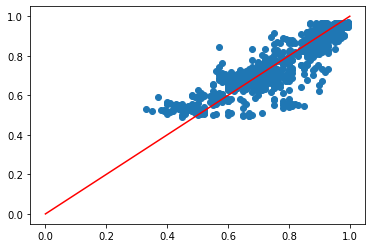

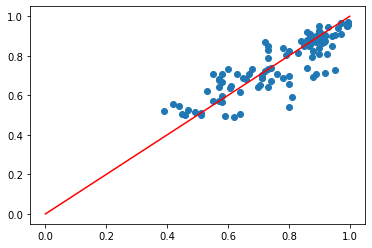

In [52]:
for epoch in range(EPOCHS):
    train(model_edge_attr, sg_train_loader, glob_v = False)
    scheduler.step()
    train_loss, train_MSE, train_r2 = test(model_edge_attr, sg_train_loader, epoch == EPOCHS - 1, glob_v = False)
    test_loss, test_MSE, test_r2 = test(model_edge_attr, sg_val_loader, epoch == EPOCHS - 1, glob_v = False)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train MSE: {train_MSE:.4f}, Test MSE: {test_MSE:.4f}, , Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')

In [53]:
#with more convolution layers
device = torch.device('cuda')
sg_train_loader = DataLoader(sg_train_data, batch_size = BATCH_SIZE, shuffle = True)
sg_val_loader = DataLoader(sg_val_data, batch_size = BATCH_SIZE, shuffle = False)

model_edge_attr = GNNModel_sg_edge_attr(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, num_layers=3, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model_edge_attr.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

Epoch: 000, Train Loss: 0.5113, Test Loss: 0.5402, Train MSE: 0.0232, Test MSE: 0.0272, , Train R2: -0.0081, Test R2: -0.0601
Epoch: 001, Train Loss: 0.5066, Test Loss: 0.5316, Train MSE: 0.0217, Test MSE: 0.0244, , Train R2: 0.0572, Test R2: 0.0483
Epoch: 002, Train Loss: 0.5068, Test Loss: 0.5312, Train MSE: 0.0218, Test MSE: 0.0243, , Train R2: 0.0552, Test R2: 0.0539
Epoch: 003, Train Loss: 0.5059, Test Loss: 0.5309, Train MSE: 0.0215, Test MSE: 0.0242, , Train R2: 0.0667, Test R2: 0.0556
Epoch: 004, Train Loss: 0.5070, Test Loss: 0.5333, Train MSE: 0.0219, Test MSE: 0.0251, , Train R2: 0.0488, Test R2: 0.0230
Epoch: 005, Train Loss: 0.5032, Test Loss: 0.5264, Train MSE: 0.0206, Test MSE: 0.0227, , Train R2: 0.1052, Test R2: 0.1156
Epoch: 006, Train Loss: 0.5000, Test Loss: 0.5221, Train MSE: 0.0195, Test MSE: 0.0212, , Train R2: 0.1533, Test R2: 0.1746
Epoch: 007, Train Loss: 0.4978, Test Loss: 0.5193, Train MSE: 0.0187, Test MSE: 0.0201, , Train R2: 0.1877, Test R2: 0.2151
Epoch:

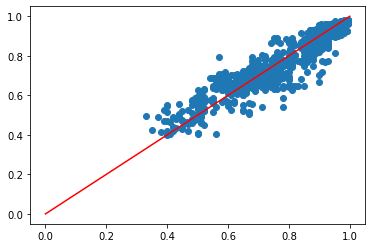

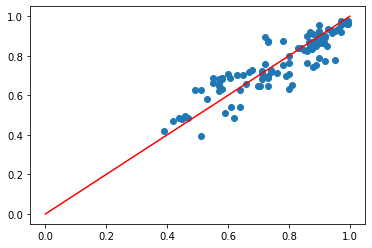

In [54]:
for epoch in range(EPOCHS):
    train(model_edge_attr, sg_train_loader, glob_v = False)
    scheduler.step()
    train_loss, train_MSE, train_r2 = test(model_edge_attr, sg_train_loader, epoch == EPOCHS - 1, glob_v = False)
    test_loss, test_MSE, test_r2 = test(model_edge_attr, sg_val_loader, epoch == EPOCHS - 1, glob_v = False)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train MSE: {train_MSE:.4f}, Test MSE: {test_MSE:.4f}, , Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')

In [20]:
#same as previous one
device = torch.device('cuda')
sg_train_loader = DataLoader(sg_train_data, batch_size = BATCH_SIZE, shuffle = True)
sg_val_loader = DataLoader(sg_val_data, batch_size = BATCH_SIZE, shuffle = False)

model_edge_attr = GNNModel_sg_edge_attr(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, num_layers=3, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model_edge_attr.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

Epoch: 000, Train Loss: 0.5104, Test Loss: 0.5335, Train MSE: 0.0229, Test MSE: 0.0250, , Train R2: 0.0046, Test R2: 0.0258
Epoch: 001, Train Loss: 0.5105, Test Loss: 0.5324, Train MSE: 0.0230, Test MSE: 0.0246, , Train R2: 0.0030, Test R2: 0.0408
Epoch: 002, Train Loss: 0.5118, Test Loss: 0.5406, Train MSE: 0.0234, Test MSE: 0.0273, , Train R2: -0.0137, Test R2: -0.0643
Epoch: 003, Train Loss: 0.5335, Test Loss: 0.5674, Train MSE: 0.0287, Test MSE: 0.0341, , Train R2: -0.2471, Test R2: -0.3285
Epoch: 004, Train Loss: 0.5011, Test Loss: 0.5253, Train MSE: 0.0200, Test MSE: 0.0224, , Train R2: 0.1333, Test R2: 0.1282
Epoch: 005, Train Loss: 0.5051, Test Loss: 0.5310, Train MSE: 0.0213, Test MSE: 0.0244, , Train R2: 0.0738, Test R2: 0.0502
Epoch: 006, Train Loss: 0.4992, Test Loss: 0.5200, Train MSE: 0.0191, Test MSE: 0.0202, , Train R2: 0.1729, Test R2: 0.2133
Epoch: 007, Train Loss: 0.4938, Test Loss: 0.5144, Train MSE: 0.0174, Test MSE: 0.0184, , Train R2: 0.2453, Test R2: 0.2830
Epoc

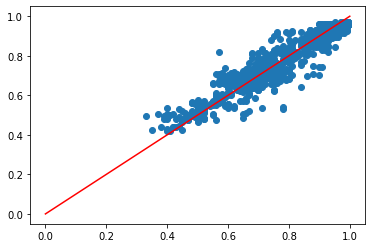

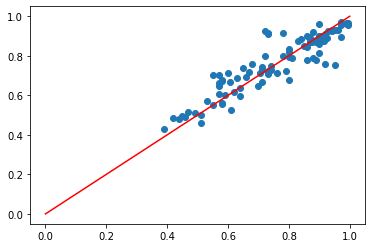

In [21]:
for epoch in range(EPOCHS):
    train(model_edge_attr, sg_train_loader, glob_v = False)
    scheduler.step()
    train_loss, train_MSE, train_r2 = test(model_edge_attr, sg_train_loader, epoch == EPOCHS - 1, glob_v = False)
    test_loss, test_MSE, test_r2 = test(model_edge_attr, sg_val_loader, epoch == EPOCHS - 1, glob_v = False)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train MSE: {train_MSE:.4f}, Test MSE: {test_MSE:.4f}, , Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')

In [22]:
#codes from here convert porportion of one enantiomer to ee% and delta delta G
%matplotlib inline
def get_test_results(model,loader, plot_flag, glob_v= True):
    model_edge_attr.eval()
    outputs = None
    targets = None
    with torch.no_grad():
        for data in loader:
            if not glob_v:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch).cpu()
            else:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.reactant_vec).cpu()
            if outputs == None:
                targets = data.y
                outputs = out
            else:
                outputs = torch.cat((outputs, out),0)
                targets = torch.cat((targets, data.y),0)
    outputs = outputs.reshape(-1)
    r2 = r2_score(targets.numpy(), outputs.numpy())
    if plot_flag:
        plt.figure()
        plt.scatter(targets.numpy(), outputs.numpy())
        x = y = np.linspace(0,1,100)
        plt.plot(x, y, '-r', label='y=x')
    return targets.numpy(), outputs.numpy()

In [23]:
train_true, train_predicted = get_test_results(model_edge_attr, sg_train_loader, False, glob_v = False)

In [26]:
val_true, val_predicted = get_test_results(model_edge_attr, sg_val_loader, False, glob_v = False)

In [28]:
train_G_true = np.log(train_true / (1 - train_true))*8.314*298/4200

In [29]:
train_G_predicted = np.log(train_predicted / (1 - train_predicted))*8.314*298/4200

In [30]:
from sklearn.metrics import mean_absolute_error

In [31]:
mean_absolute_error(train_G_true, train_G_predicted)

0.19841337

In [32]:
val_G_true = np.log(val_true / (1 - val_true))*8.314*298/4200

In [33]:
val_G_predicted = np.log(val_predicted / (1 - val_predicted))*8.314*298/4200

In [34]:
mean_absolute_error(val_G_true, val_G_predicted)

0.23352773

C:\Users\Haoyu Fan\AppData\Local\Temp\ipykernel_11412\3316336120.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y, '-r',linestyle='dashed', label='y=x')


<Figure size 432x288 with 0 Axes>

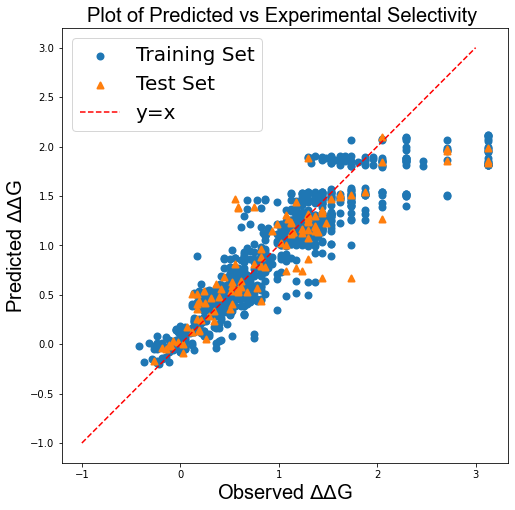

In [78]:
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(train_G_true, train_G_predicted,marker='o',linewidths=2, label="Training Set")
ax.scatter(val_G_true,val_G_predicted,marker='^',linewidths=2, label="Test Set")
x = y = np.linspace(-1,3,100)
ax.set_xlabel(r'Observed $ \Delta \Delta$G', size = 20, fontname="Arial")
ax.set_ylabel(r'Predicted $ \Delta \Delta$G', size = 20, fontname="Arial")
ax.set_title('Plot of Predicted vs Experimental Selectivity ', size = 20, fontname="Arial")
ax.plot(x, y, '-r',linestyle='dashed', label='y=x')
ax.legend(fontsize=20)
plt.savefig("ddG.png")

In [61]:
r2_score(val_G_true, val_G_predicted)

0.7513103534682684

In [62]:
from sklearn.metrics import mean_squared_error as MSE

In [63]:
MSE(val_G_true, val_G_predicted)

0.1343066

In [65]:
train_ee_true = train_true - (1-train_true)
train_ee_predicted = train_predicted - (1-train_predicted)

In [66]:
val_ee_true = val_true - (1-val_true)
val_ee_predicted = val_predicted - (1-val_predicted)

C:\Users\Haoyu Fan\AppData\Local\Temp\ipykernel_11412\2370208631.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y, '-r',linestyle='dashed', label='y=x')


<Figure size 432x288 with 0 Axes>

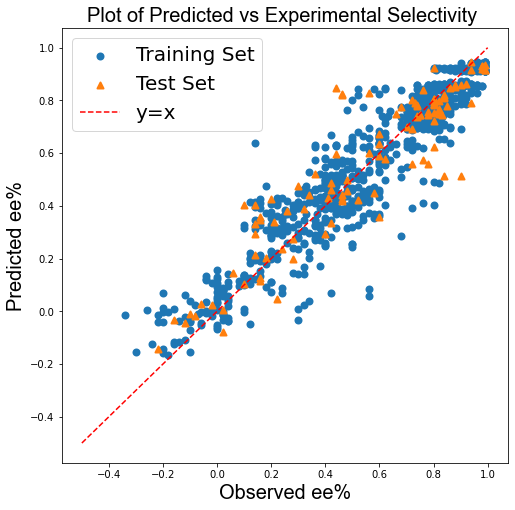

In [79]:
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(train_ee_true, train_ee_predicted,marker='o',linewidths=2,label="Training Set")
ax.scatter(val_ee_true,val_ee_predicted,marker='^',linewidths=2, label="Test Set")
x = y = np.linspace(-0.5,1,100)
ax.set_xlabel(r'Observed ee%', size = 20, fontname="Arial")
ax.set_ylabel(r'Predicted ee%', size = 20, fontname="Arial")
ax.set_title('Plot of Predicted vs Experimental Selectivity ', size = 20, fontname="Arial")
ax.plot(x, y, '-r',linestyle='dashed', label='y=x')
ax.legend(fontsize=20)
plt.savefig("ee.png")

In [75]:
r2_score(val_ee_true, val_ee_predicted)

0.842194871477553

In [76]:
MSE(val_ee_true, val_ee_predicted)

0.016203174